In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


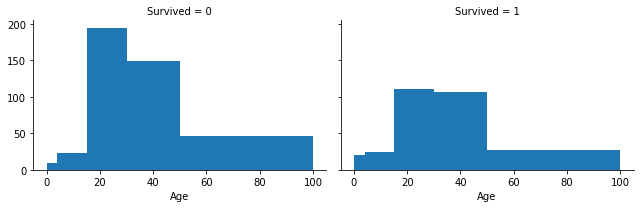

In [3]:
g = sns.FacetGrid(train_data, col='Survived', aspect=1.5)
g.map(plt.hist, 'Age', bins=[0,4,15,30,50,100])

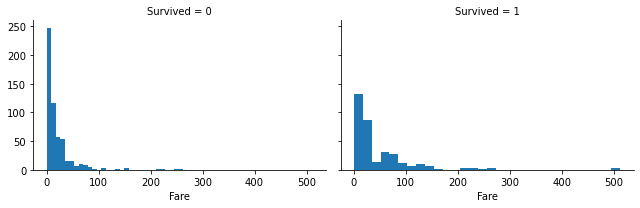

In [4]:
g = sns.FacetGrid(train_data, col='Survived', aspect=1.5)
g.map(plt.hist, 'Fare', bins=30)

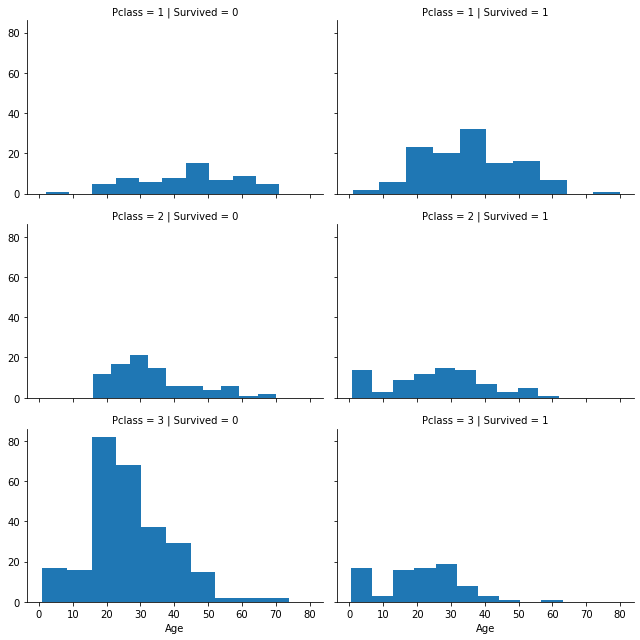

In [5]:
g = sns.FacetGrid(train_data, row='Pclass', col='Survived', aspect=1.5)
g.map(plt.hist, 'Age')

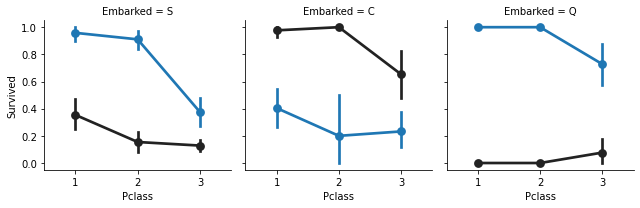

In [6]:
g = sns.FacetGrid(train_data, col='Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')

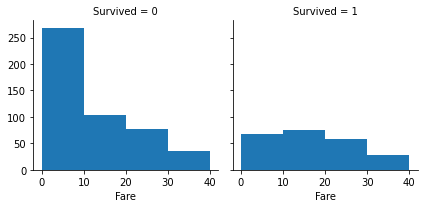

In [7]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Fare', bins=[0, 10, 20, 30, 40])

## Data processing

In [8]:
both = [train_data, test_data]

for ds in both:
    ds['Sex'] = ds['Sex'].map({'female': 0, 'male': 1})

In [9]:
todrop = ['Ticket', 'Cabin']
for ds in both:
    ds.drop(todrop, axis=1, inplace=True)

In [10]:
for ds in both:
    ds['Title'] = ds['Name'].str.extract(' ([A-Za-z]+\.)')

In [11]:
train_data[['Title', 'Survived']].groupby('Title').agg(['count', 'mean'])
title2val = {'Mr.': 0, 'Master.': 1, 'Miss.': 2, 'Mrs.': 3}
def title2val_func(title):
    if title in title2val.keys():
        return title2val[title]
    else:
        return 4
for ds in both:
    ds['Title'] = ds['Title'].apply(title2val_func)
    ds.drop('Name', axis=1, inplace=True)

In [12]:
train_data.dropna(axis=0, subset=['Embarked'], inplace=True)

In [13]:
for ds in both:
    ds['Families'] = ds['SibSp'] + ds['Parch']
    ds['Alone'] = (ds['Families'] == 0).map({False: 0, True: 1})
    ds.drop(['Families', 'SibSp', 'Parch'], axis=1, inplace=True)

In [14]:
train_data[['Embarked', 'Survived']].groupby('Embarked').mean()
for ds in both:
    ds['Embarked'] = ds['Embarked'].map({'S': 0, 'Q': 1, 'C': 2})

In [15]:
age_guess = train_data.groupby(['Title', 'Pclass'])['Age'].mean()
for title in [0, 1, 2, 3, 4]:
    for pclass in [1, 2, 3]:
        if (title, pclass) not in age_guess.index:
            ds.loc[ds['Age'].isna() & (ds['Title'] == title), 'Age'] = age_guess.loc[title].mean()
        else:
            for ds in both:
                ds.loc[ds['Age'].isna() & (ds['Title'] == title) & (ds['Pclass'] == pclass), 'Age'] = age_guess[title, pclass] 

fare_guess = train_data.groupby(['Pclass'])['Fare'].mean()
for pclass in [1, 2, 3]:
    for ds in both:
        ds.loc[ds['Fare'].isna() & (ds['Pclass'] == pclass), 'Fare'] = fare_guess[pclass] 

In [16]:
from bisect import bisect
ages = [0,4,15,30,50,100]
fares = [0,10,25,50,100,1e9]

for ds in both:
    ds['AgeBand'] = ds['Age'].apply(lambda x: bisect(ages, x))
    ds['FareBand'] = ds['Fare'].apply(lambda x: bisect(fares, x))
    # ds.drop(['Age', 'Fare'], axis=1, inplace=True)

## Start training

In [17]:
from sklearn.ensemble import RandomForestClassifier

y = train_data['Survived']
features = [f for f in test_data.columns if f != 'PassengerId']
X = pd.get_dummies(train_data[features], columns=['Pclass', 'Embarked', 'Title'])
X_test = pd.get_dummies(test_data[features], columns=['Pclass', 'Embarked', 'Title'])

In [18]:
X_test

,Sex,Age,Fare,Alone,AgeBand,FareBand,Pclass_1,Pclass_2,Pclass_3,Embarked_0,Embarked_1,Embarked_2,Title_0,Title_1,Title_2,Title_3,Title_4
0,1,34.500000,7.8292,1,4,1,0,0,1,0,1,0,1,0,0,0,0
1,0,47.000000,7.0000,0,4,1,0,0,1,1,0,0,0,0,0,1,0
2,1,62.000000,9.6875,1,5,1,0,1,0,0,1,0,1,0,0,0,0
3,1,27.000000,8.6625,1,3,1,0,0,1,1,0,0,1,0,0,0,0
4,0,22.000000,12.2875,0,3,2,0,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,28.724891,8.0500,1,3,1,0,0,1,1,0,0,1,0,0,0,0
414,0,39.000000,108.9000,1,4,5,1,0,0,0,0,1,0,0,0,0,1
415,1,38.500000,7.2500,1,4,1,0,0,1,1,0,0,1,0,0,0,0
416,1,28.724891,8.0500,1,3,1,0,0,1,1,0,0,1,0,0,0,0


In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model.fit(X, y)
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})

In [20]:
output.to_csv('submission_0804-4_rf.csv', index=False)